### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import time
from preprocess import clahe, sectioning, sectioning_valid, display_sections, hist_equalization
from feature_extraction import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

<function matplotlib.pyplot.show(close=None, block=None)>

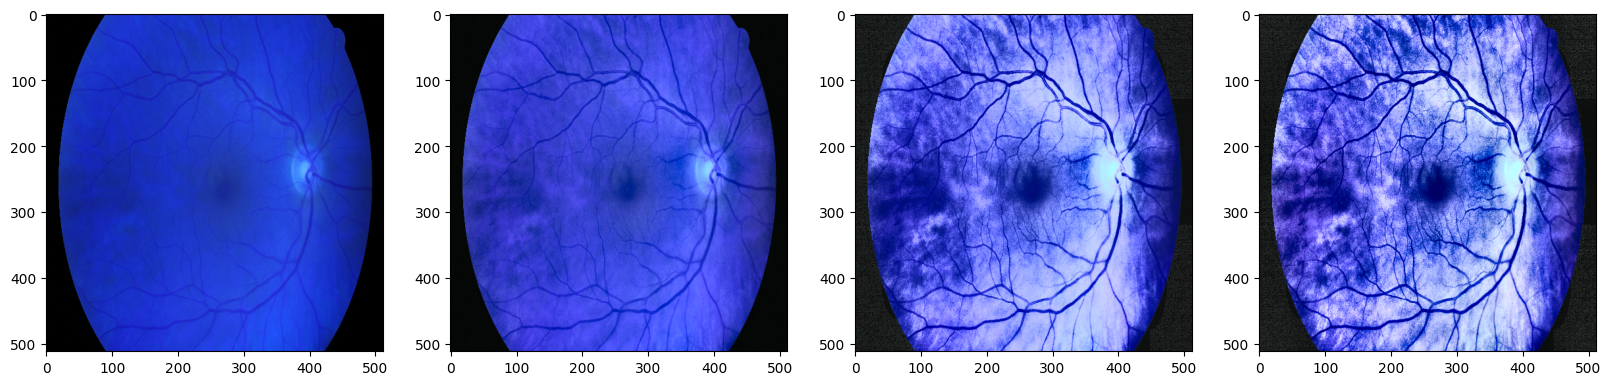

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(20,15))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahe(X[1]), cmap='gray')
ax[2].imshow(hist_equalization(clahe(X[1])) , cmap='gray')
ax[3].imshow(clahe(hist_equalization(clahe(X[1]))) , cmap='gray')
plt.show

### Split image to NxN sections

Img padded shape:  (512, 512, 3)
Target padded shape:  (512, 512)


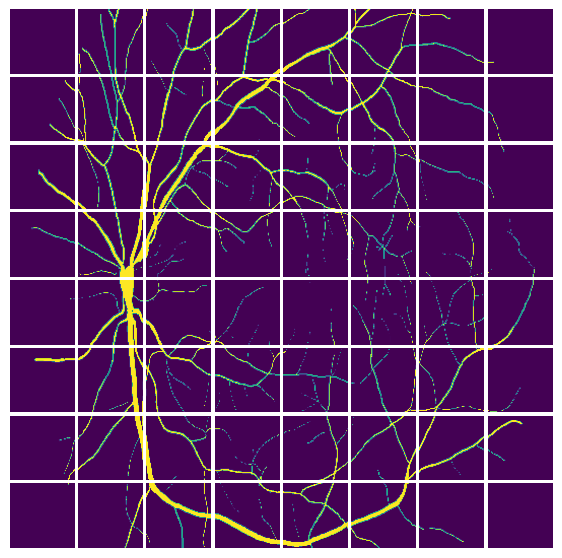

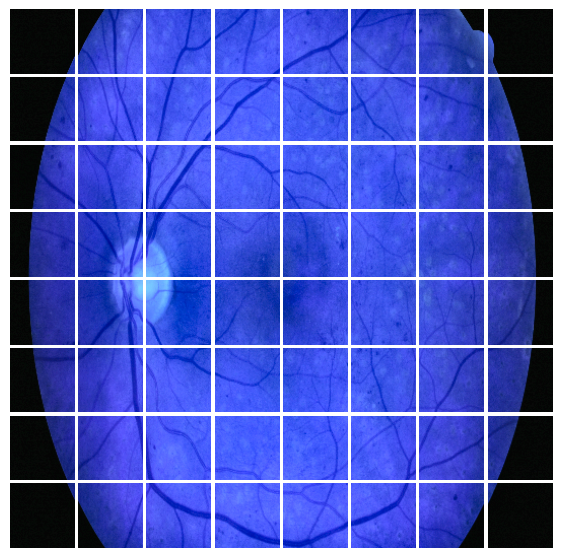

In [4]:
# Not used at proper solution - but looks cool
N = 64
sections, targets, section_size, target_size = sectioning(clahe(X[0]), y[0], N, debug=True)
display_sections(targets, target_size, N)
display_sections(sections, section_size, N)

In [5]:
# THOSE SECTION WILL BE PASSED TO CLASSIFIER WITH CORRESPONDING LABELS - PIXELS FROM TARGET IMG
sections = sectioning_valid(clahe(X[0]), 5)

512 512


### Feature Extraction

In [6]:
sample_feature_vect = feature_extraction(sections[0], debug=True)

Mean:  2.1733333333333333
Std:  3.2015551776528155
Peaks No.:  2
Entropy:  1.0353266957705896
Skewness:  13.851865759867826
RGB varation:  [8.7936, 13.929600000000002, 7.833599999999999]
HU moments: [2.41309968e-02 1.32041952e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


### Convert sections to feature vectors

In [7]:
num_features = 15

section_features = np.zeros((sections.shape[0], num_features))

start = time.time()
for i in range(sections.shape[0]):
    section_features[i] = feature_extraction(sections[i])
stop = time.time()
duration = stop - start
duration # 15 features ~2mins; 10 features ~15s

106.7984926700592

In [8]:
# from numba import njit, prange

# num_features = 15
# section_features = np.zeros((sections_valid.shape[0], num_features))

# @njit(parallel=True)
# def parallel_feature_extraction(sections_valid, section_features):
#     for i in prange(sections_valid.shape[0]):
#         section_features[i] = feature_extraction_(sections_valid[i])

# sections_valid_np = np.array(sections_valid)
# section_features_np = np.zeros((sections_valid_np.shape[0], num_features))
# parallel_feature_extraction(sections_valid_np, section_features_np)

In [9]:
target = y[0].flatten()
target = target / 128
target[target>1] = 1
target[target<1] = 0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(section_features, target, test_size=0.2, shuffle=True)

In [11]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     49776
         1.0       0.55      0.34      0.42      2653

    accuracy                           0.95     52429
   macro avg       0.76      0.66      0.70     52429
weighted avg       0.94      0.95      0.95     52429



In [12]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     49776
         1.0       0.51      0.54      0.52      2653

    accuracy                           0.95     52429
   macro avg       0.74      0.76      0.75     52429
weighted avg       0.95      0.95      0.95     52429



In [13]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     49776
         1.0       0.79      0.45      0.57      2653

    accuracy                           0.97     52429
   macro avg       0.88      0.72      0.78     52429
weighted avg       0.96      0.97      0.96     52429



In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     49776
         1.0       0.57      0.23      0.33      2653

    accuracy                           0.95     52429
   macro avg       0.77      0.61      0.65     52429
weighted avg       0.94      0.95      0.94     52429



/home/kamil/anaconda3/envs/data_science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     49776
         1.0       0.77      0.58      0.66      2653

    accuracy                           0.97     52429
   macro avg       0.87      0.79      0.82     52429
weighted avg       0.97      0.97      0.97     52429



### Performance on other image

In [ ]:
sections = sectioning_valid(clahe(X[1]), 5)
X_new = np.zeros((sections.shape[0], num_features))

for i in range(sections.shape[0]):
    X_new[i] = feature_extraction(sections[i])

y_new = y[1].flatten()
y_new = y_new / 128
y_new[y_new>1] = 1
y_new[y_new<1] = 0

512 512


In [ ]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
y_pred_new = xgb_clf.predict(X_new)

In [ ]:
print(f'Train set: \n {classification_report(y_pred_train, y_train)}')
print('------------------------------------------------------\n')
print(f'Test set: \n {classification_report(y_pred_test, y_test)}')
print('------------------------------------------------------\n')
print(f'Different image: \n{classification_report(y_pred_new, y_new)}')

In [ ]:
y_new = y_new.reshape(img_size)
y_pred_new = y_pred_new.reshape(img_size)

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y_new)
ax[1].imshow(y_pred_new)
plt.show()